Optimization Pulse Stimulus on Nerve
====================================

This example is an extantion of the tutorial [Tuorial 5](../../tutorials/5_first_optimization.rst), the optimization formalism used in NRV is illustrated through a detailed example.

The objective of the first optimization problem is to **minimize a rectangle pulse stimulus energy required by a LIFE-electrode to trigger a single myelinated fibre**.

.. note::
    This example is run with only run on a 30-fibres nerve, for a small optimization (15 PSO particles, 40 iterations). Those parameters could be increase for a more realistic problem.

.. Tip::
    This code is *multicore friendly*, computation time could be reduced a lot by running the script on `N` cores the following command (see [MCH](../../usersguide/parallel.rst))

        mpirun -n N python example_o01.py

NRV INFO: On 30 axons to generate, there are 30 Myelinated and 0 Unmyelinated
NRV INFO: Axon packing initiated. This might take a while...


100%|██████████| 20000/20000 [00:00<00:00, 33466.52it/s]


NRV INFO: Packing done!
NRV INFO: From Fascicle 0: Electrode/Axons overlap, 1 axons will be removed from the fascicle
NRV INFO: 30 axons remaining
NRV INFO: Mesh properties:
NRV INFO: Number of processes : 3
NRV INFO: Number of entities : 36
NRV INFO: Number of nodes : 8917
NRV INFO: Number of elements : 62380
NRV INFO: Static/Quasi-Static electrical current problem
NRV INFO: FEN4NRV: setup the bilinear form
NRV INFO: FEN4NRV: setup the linear form
NRV INFO: Static/Quasi-Static electrical current problem
NRV INFO: FEN4NRV: solving electrical potential
NRV INFO: FEN4NRV: solved in 2.9086241722106934 s


pyswarms.single.general_optimizer: 100%|██████████|40/40, best_cost=0.228


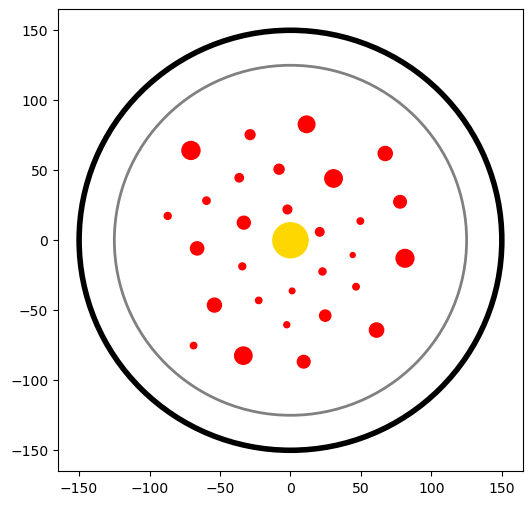

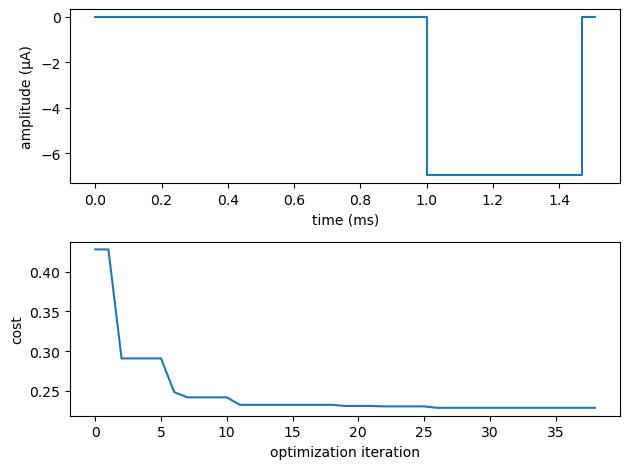

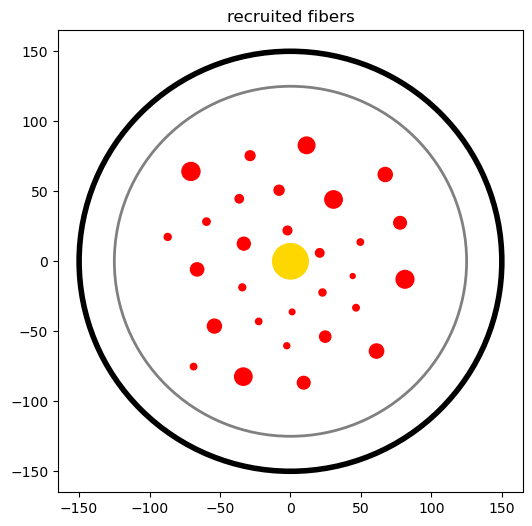

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import nrv

np.random.seed(4444)

test_name = "Example_"
dir_res = f"./{test_name}/"
if not os.path.isdir(dir_res):
    os.mkdir(dir_res)

## Cost function definition
my_cost0 = nrv.cost_function()

# Static context
nerve_file = dir_res + "nerve.json"

outer_d = 5 # mm
nerve_d = 300 # um
nerve_l = 5000 # um

fasc1_d = 250 # um
fasc1_y = 0
fasc1_z = 0
n_ax1 = 30


nerve_1 = nrv.nerve(length=nerve_l, diameter=nerve_d, Outer_D=outer_d)
nerve_1.verbose = False
axons_diameters, axons_type, M_diam_list, U_diam_list = nrv.create_axon_population(n_ax1, percent_unmyel=0, M_stat="Ochoa_M", U_stat="Ochoa_U",)

fascicle_1 = nrv.fascicle(ID=0)      #we can add diameter here / no need to call define_circular_contour (not tested)
fascicle_1.define_circular_contour(fasc1_d)
fascicle_1.fill_with_population(axons_diameters, axons_type, fit_to_size=True,delta=5)
fascicle_1.generate_random_NoR_position()
nerve_1.add_fascicle(fascicle=fascicle_1, y=fasc1_y, z=fasc1_z)

# LIFE in neither of the two fascicles
LIFE_stim0 = nrv.FEM_stimulation()
LIFE_stim0.reshape_nerve(Length=nerve_l)
life_d = 25 # um
life_length = 1000 # um
life_x_0_offset = life_length/2
life_y_c_0 = 0
life_z_c_0 = 0
elec_0 = nrv.LIFE_electrode("LIFE", life_d, life_length, life_x_0_offset, life_y_c_0, life_z_c_0)

dummy_stim = nrv.stimulus()
dummy_stim.pulse(0, 0.1, 10)
LIFE_stim0.add_electrode(elec_0, dummy_stim)
nerve_1.attach_extracellular_stimulation(LIFE_stim0)

fig, ax = plt.subplots(1, 1, figsize=(6,6))
nerve_1.plot(ax)

nerve_1.compute_electrodes_footprints()
nerve_1.set_parameters(postproc_script="is_recruited")
_ = nerve_1.save(fname=nerve_file, extracel_context=True)
nrv.synchronize_processes()
#nerve_1(t_sim=5)
del nerve_1


t_sim = 5
dt = 0.005
kwarg_sim = {
    "dt":dt,
    "t_sim":t_sim,
}

static_context = nerve_file
my_cost0.set_static_context(static_context, **kwarg_sim)

# Context modifier
t_start = 1
I_max_abs = 100

cm_0 = nrv.biphasic_stimulus_CM(start=t_start, s_cathod="0", t_cathod="1", s_anod=0)
my_cost0.set_context_modifier(cm_0)

# Cost evaluation
costR = nrv.recrutement_count_CE(reverse=True)
costC = nrv.stim_energy_CE()

cost_evaluation = costR + 0.01 * costC
my_cost0.set_cost_evaluation(cost_evaluation)


## Optimizer
pso_kwargs = {
    "maxiter" : 40,
    "n_particles" : 20,
    "opt_type" : "local",
    "options": {'c1': 0.55, 'c2': 0.55, 'w': 0.75, 'k': 2, 'p': 1},
    "bh_strategy": "reflective",
}
pso_opt = nrv.PSO_optimizer(**pso_kwargs)

## Problem definition
my_prob = nrv.Problem()
my_prob.costfunction = my_cost0
my_prob.optimizer = pso_opt


# Optimization
t_end = 0.5
bounds0 = (
    (0, I_max_abs),
    (0.01, t_end),
)
pso_kwargs_pb_0 = {
    "dimensions" : 2,
    "bounds" : bounds0,
    "comment":"pulse"}

res0 = my_prob(**pso_kwargs_pb_0)

res_sim = res0.compute_best_pos(my_cost0)

# Plot results on master process
if nrv.MCH.do_master_only_work():
    fig_costs, axs_costs = plt.subplots(2, 1)

    stim = cm_0(res0.x, static_context).extra_stim.stimuli[0]
    stim.plot(axs_costs[0])
    axs_costs[0].set_xlabel("best stimulus shape")
    axs_costs[0].set_xlabel("time (ms)")
    axs_costs[0].set_ylabel("amplitude (µA)")

    res0.plot_cost_history(axs_costs[1])
    axs_costs[1].set_xlabel("optimization iteration")
    axs_costs[1].set_ylabel("cost")
    fig_costs.tight_layout()

    fig_best, ax_best = plt.subplots(figsize=(6,6))
    ax_best.set_title("recruited fibers")
    res_sim.plot_recruited_fibers(ax_best)
